# Solar Radiation Prediction

# Importing Libraries

In [4]:
import warnings
import re
import numpy as np
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from collections import Counter
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
warnings.filterwarnings("ignore")

In [6]:
plt.rcParams['figure.figsize'] = (12,6)

# Loading Data

In [11]:
data = pd.read_csv("SolarPrediction.csv")

In [12]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [13]:
data.shape

(32686, 11)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [15]:
df = data.copy()

In [16]:
# extract the date from the date_time format of the 'Data' parameter

df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [17]:
# extract the date time features from the given parameter using date time python methods

df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [18]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [19]:
# extract the sunrise and sunset information using regular expression

df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [20]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [21]:
# drop the parameters that are not required after extracting the relevant information

df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [22]:
df.shape

(32686, 15)

In [23]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [24]:
np.array(df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [25]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

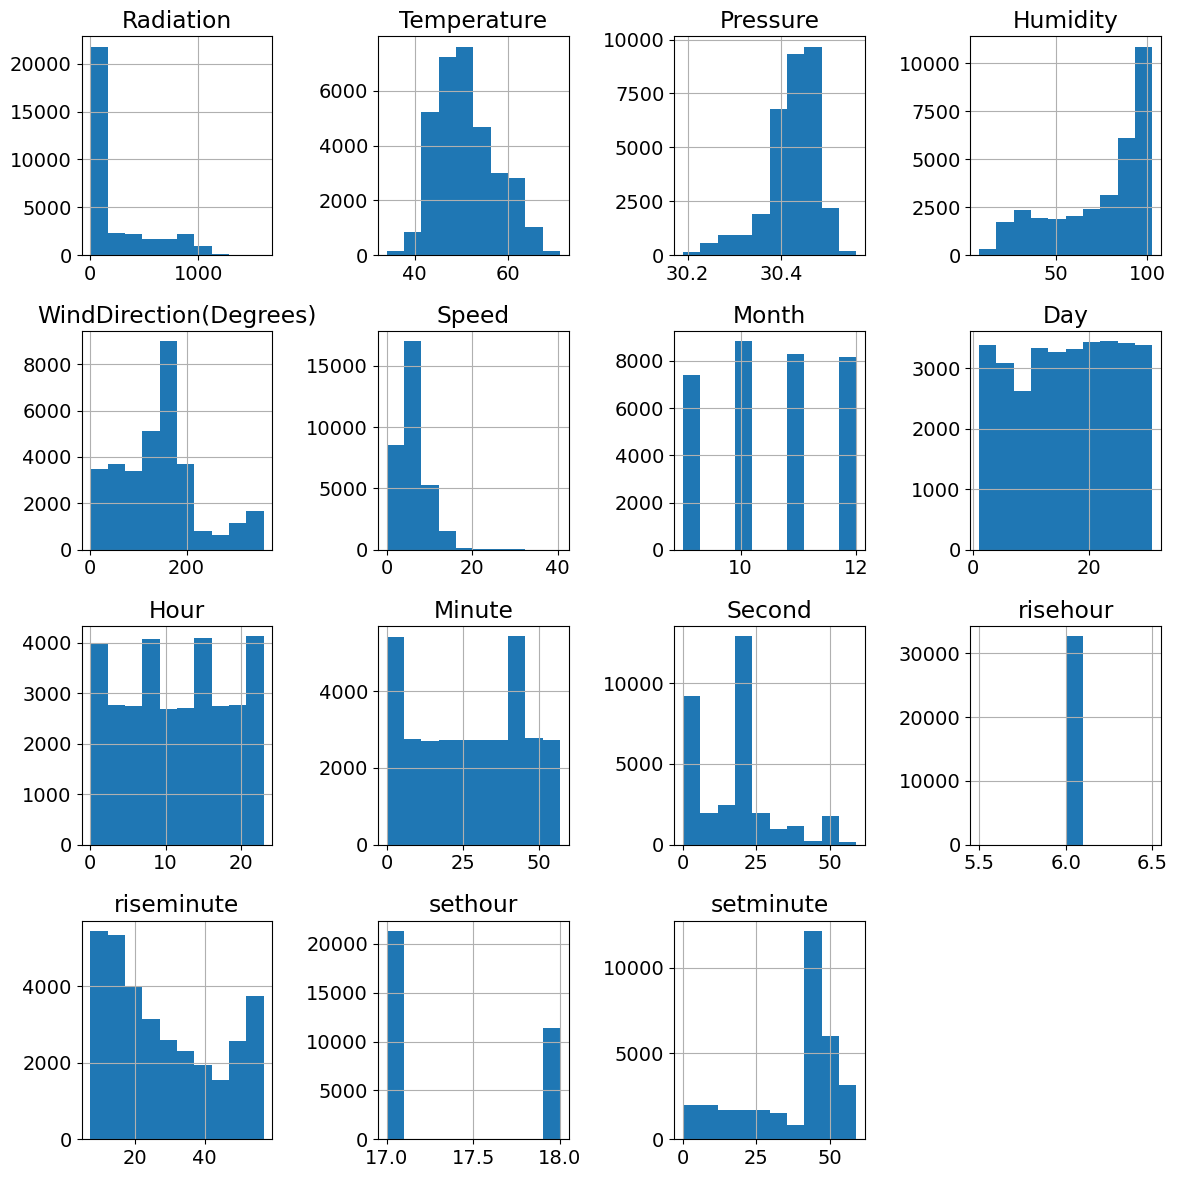

In [26]:
plt.rcParams["font.size"] = 14
df.hist(figsize=(12,12))
plt.tight_layout()
plt.show()


# SCATTER PLOT

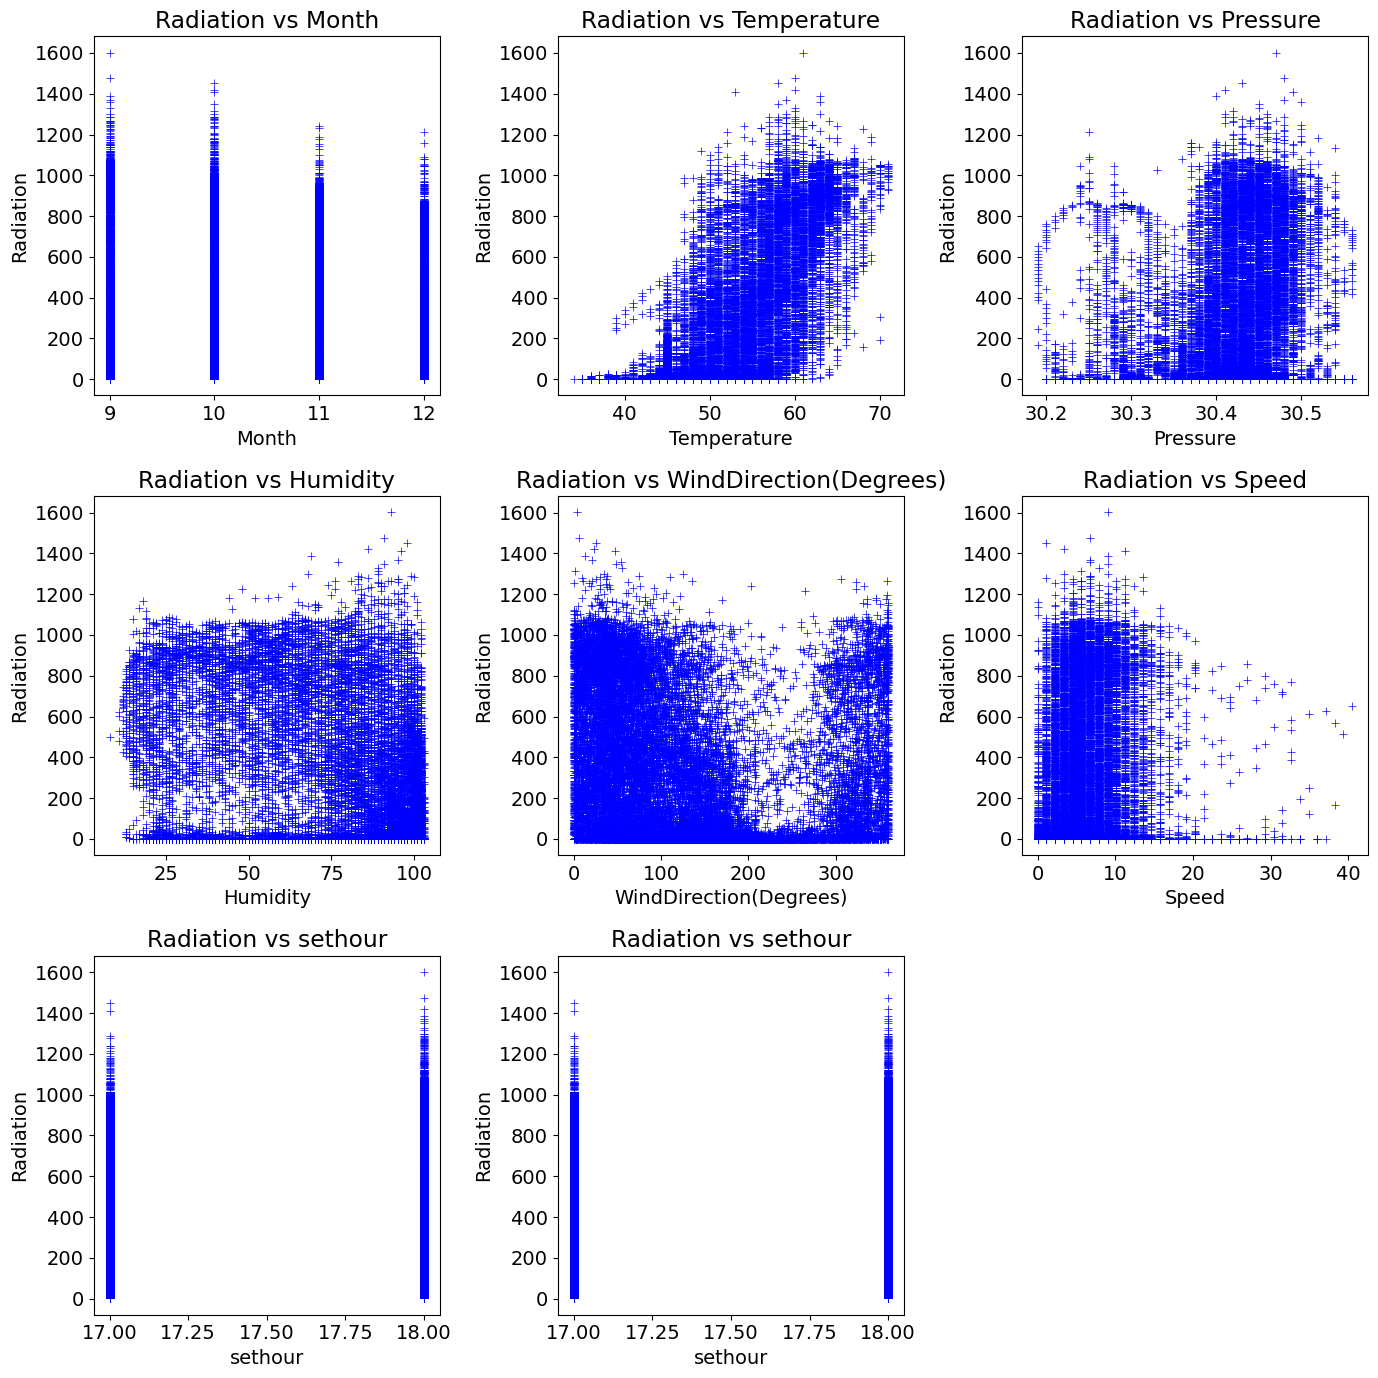

In [27]:
plt.rcParams["figure.figsize"] = (14, 14)
plt.rcParams["font.size"] = 14

ylabel = 'Radiation'
columns = [ 'Month', 'Temperature',	'Pressure',	'Humidity',	'WindDirection(Degrees)',	'Speed',	'sethour',	'sethour']

for index, xlabel in enumerate(columns):
  plt.subplot(3, 3, index+1)
  plt.scatter(df[xlabel], df[ylabel],color='blue',marker='+',linewidth=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(ylabel + ' vs ' + xlabel)

plt.tight_layout()

# Feature Selection using Correlation Matrix

$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable

In [28]:
# extract the correlation between the data features

df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


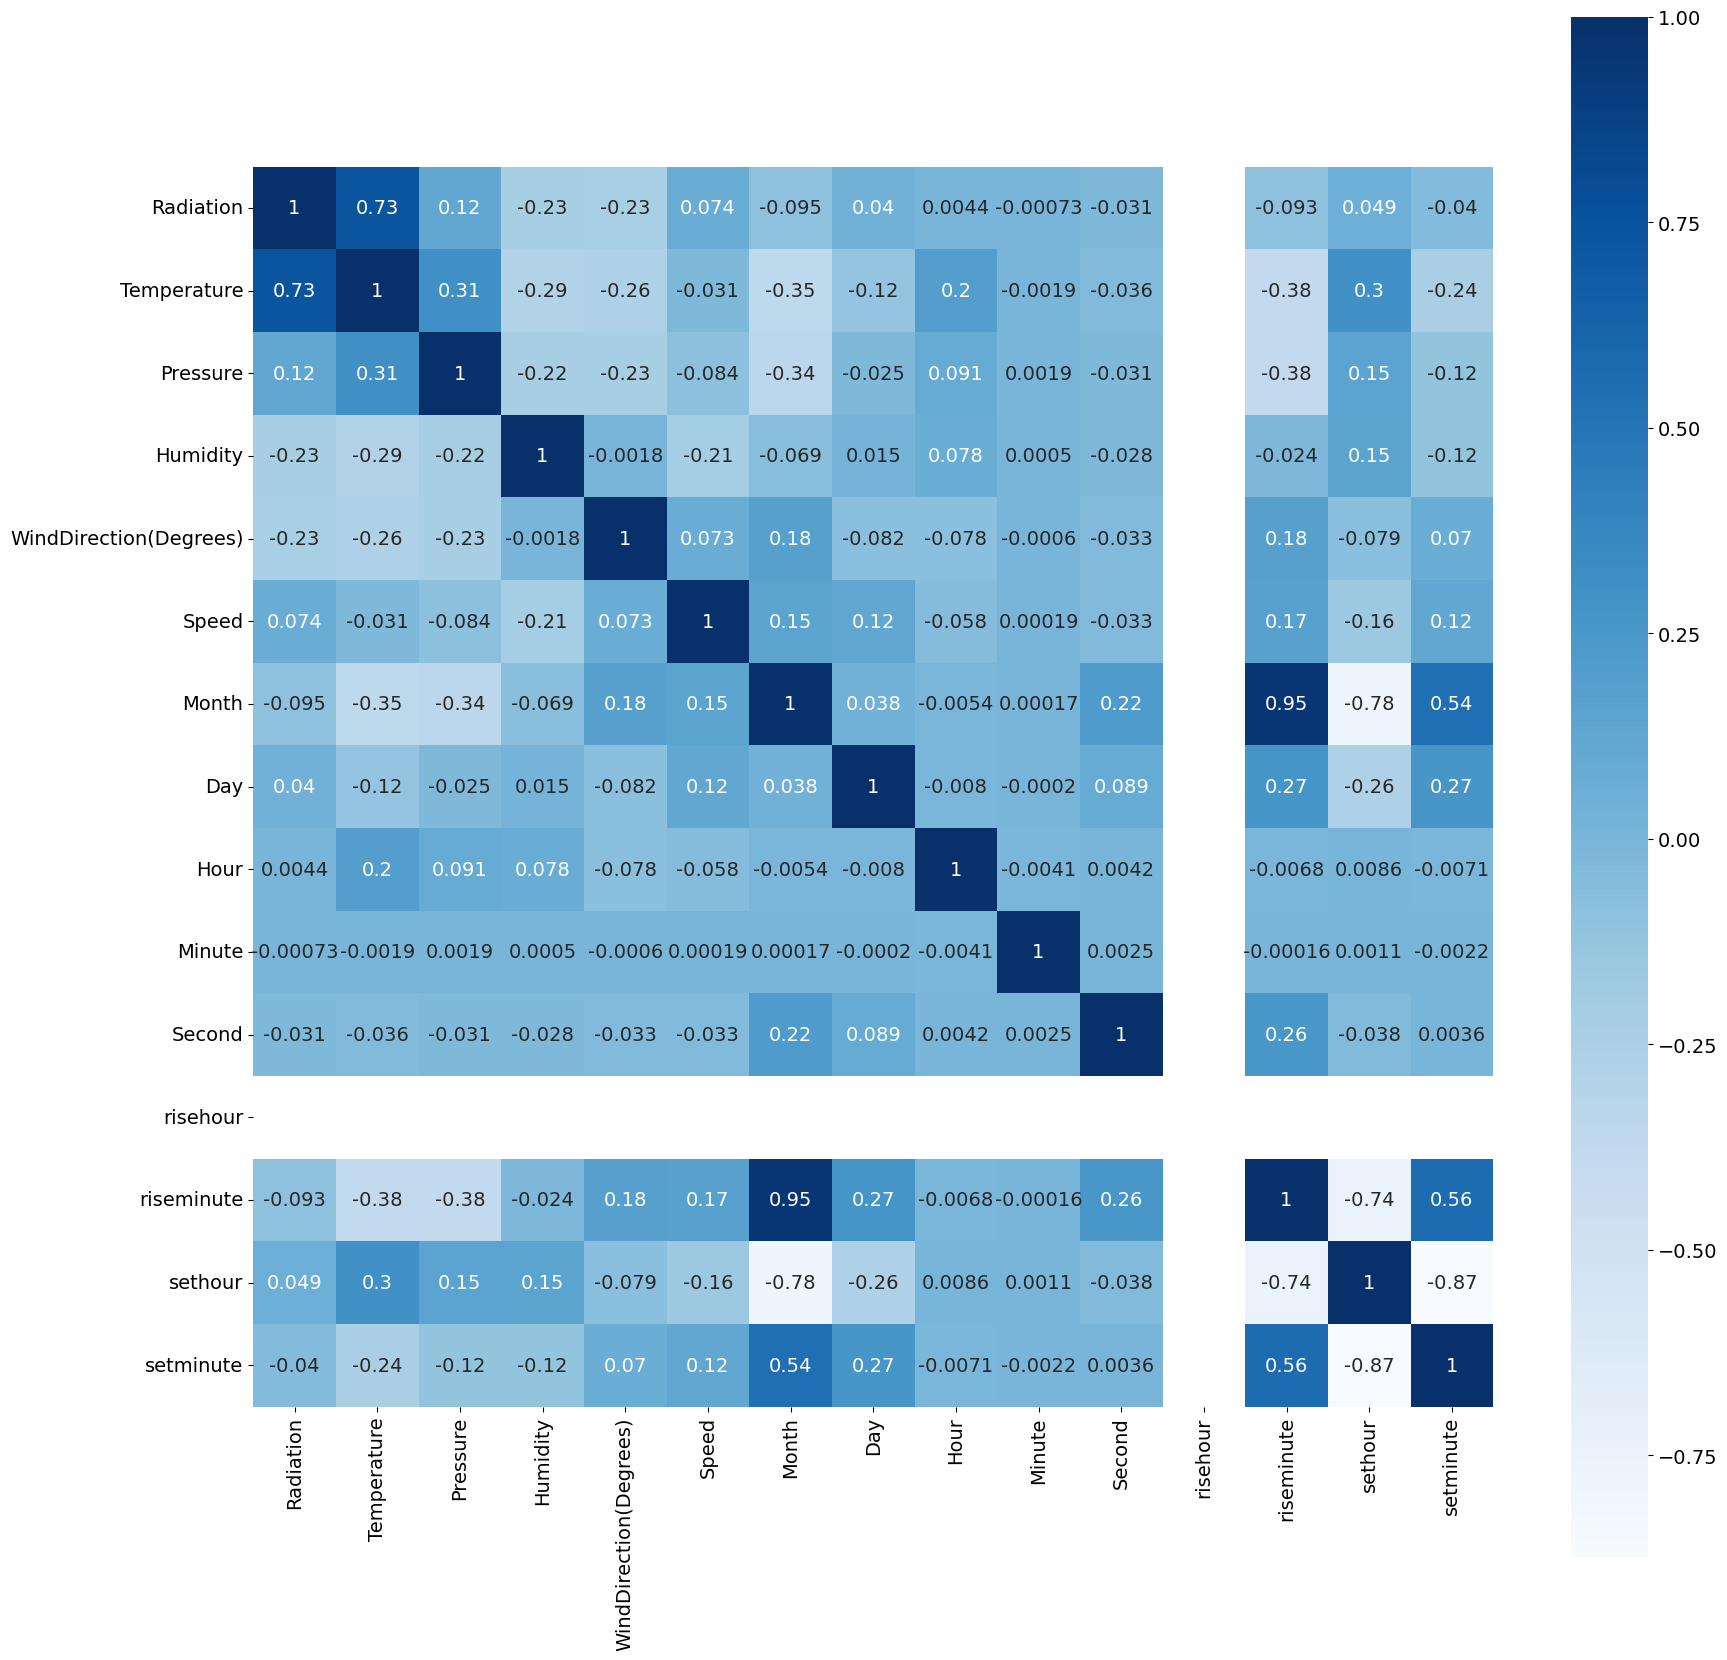

<Figure size 1400x1400 with 0 Axes>

In [29]:
# plot the correlation matrix using heatmap for clear understanding

plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot = True,square=True, cmap='Blues')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()


# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

In [30]:
input_features

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,44,30.43,102,145.42,6.75,12,1,0,20,4,6,41,17,42
32682,44,30.42,102,117.78,6.75,12,1,0,15,1,6,41,17,42
32683,44,30.42,102,145.19,9.00,12,1,0,10,1,6,41,17,42
32684,44,30.42,101,164.19,7.87,12,1,0,5,2,6,41,17,42


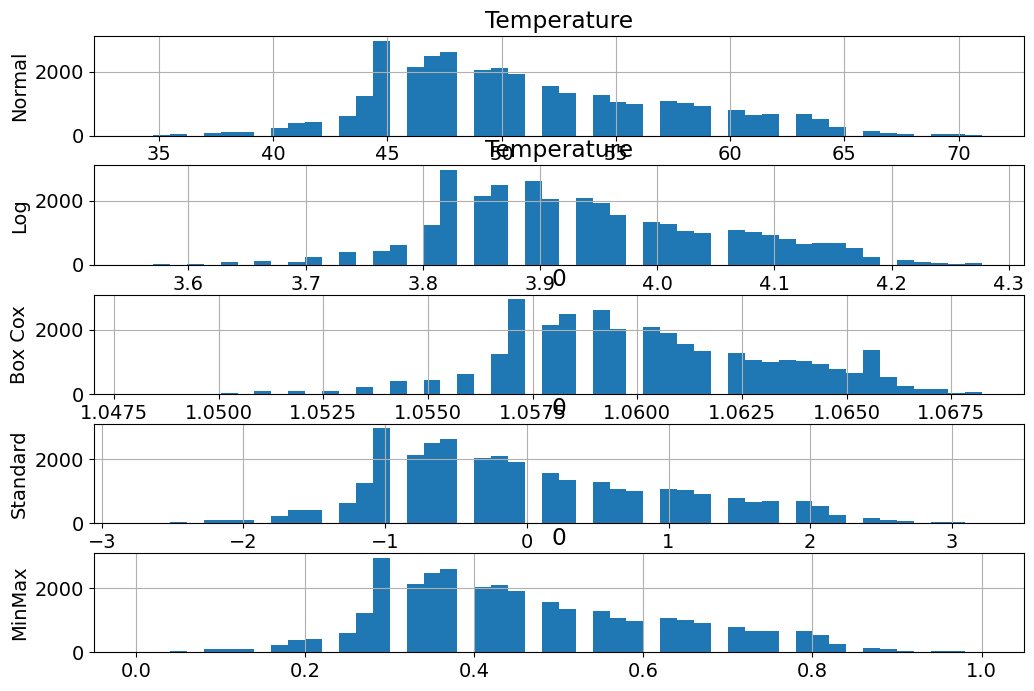

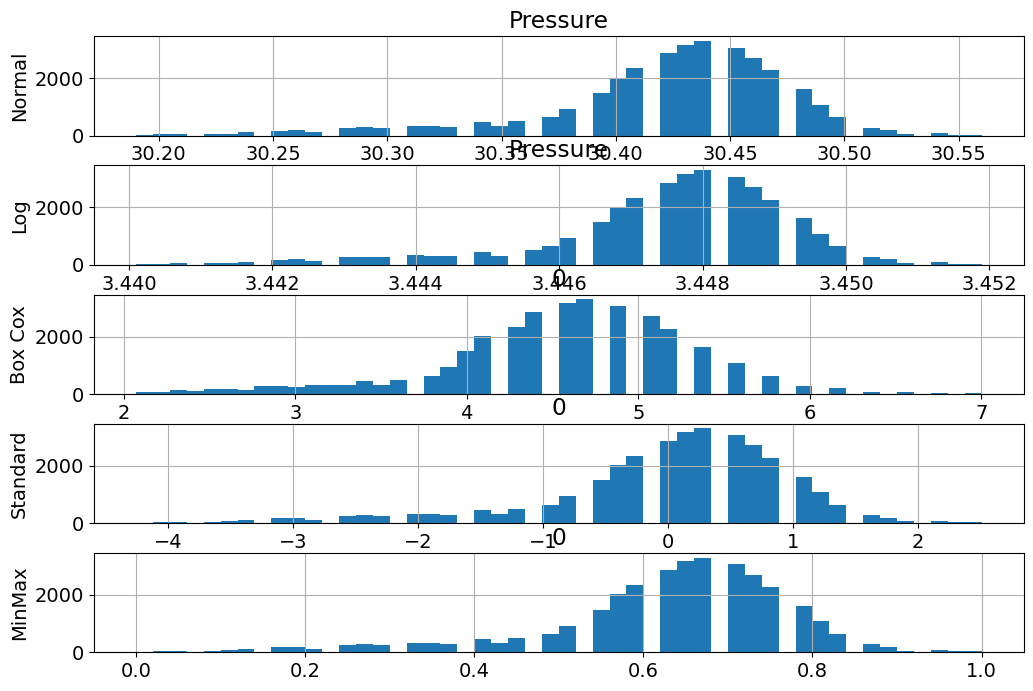

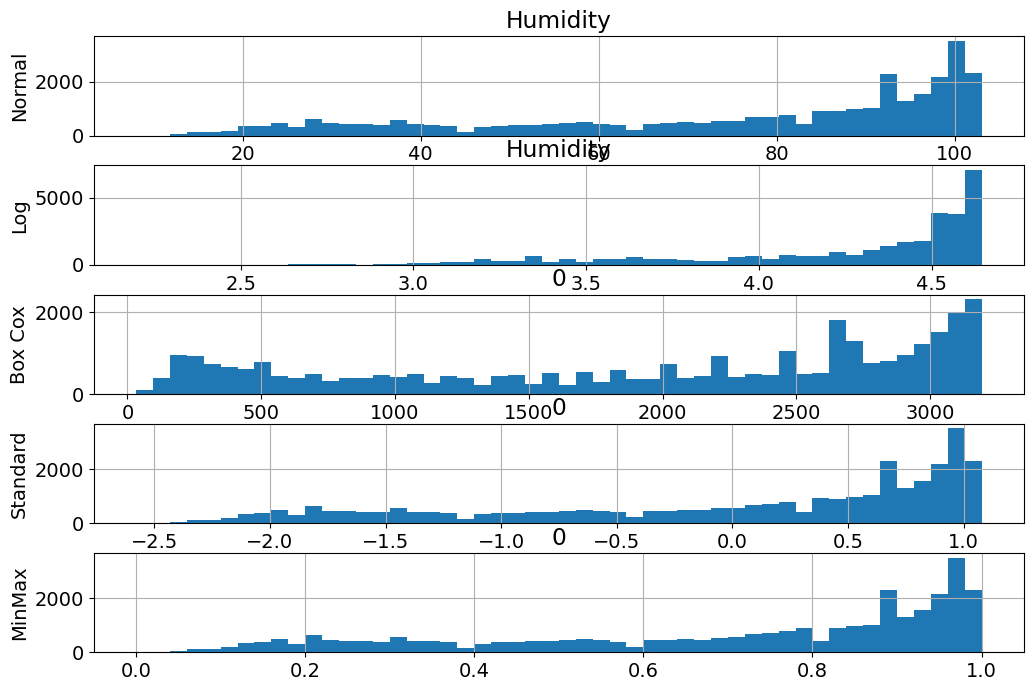

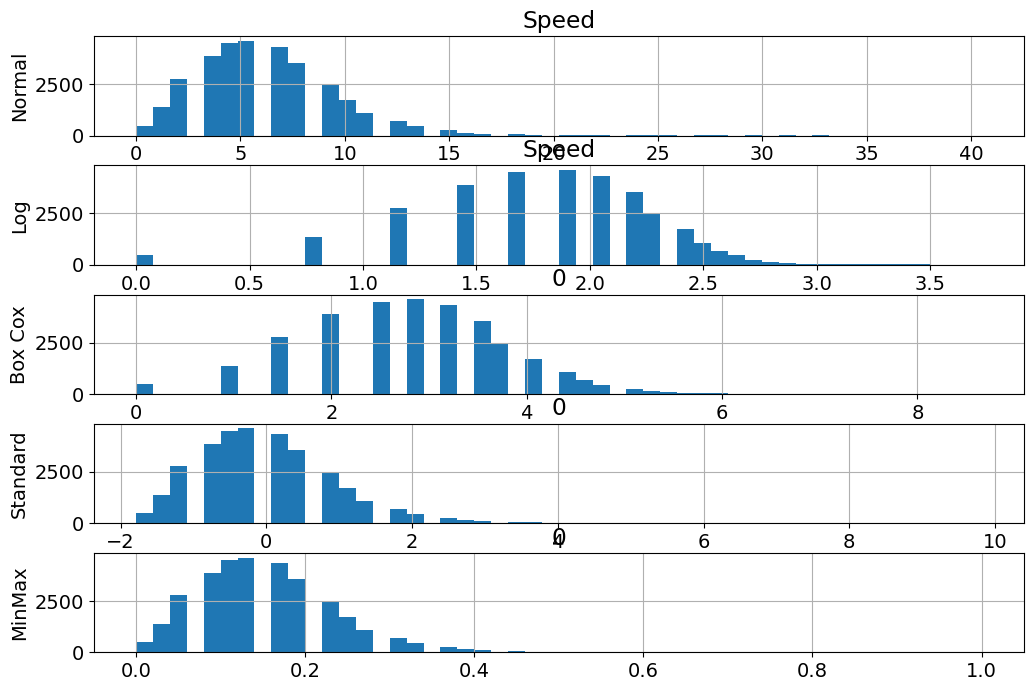

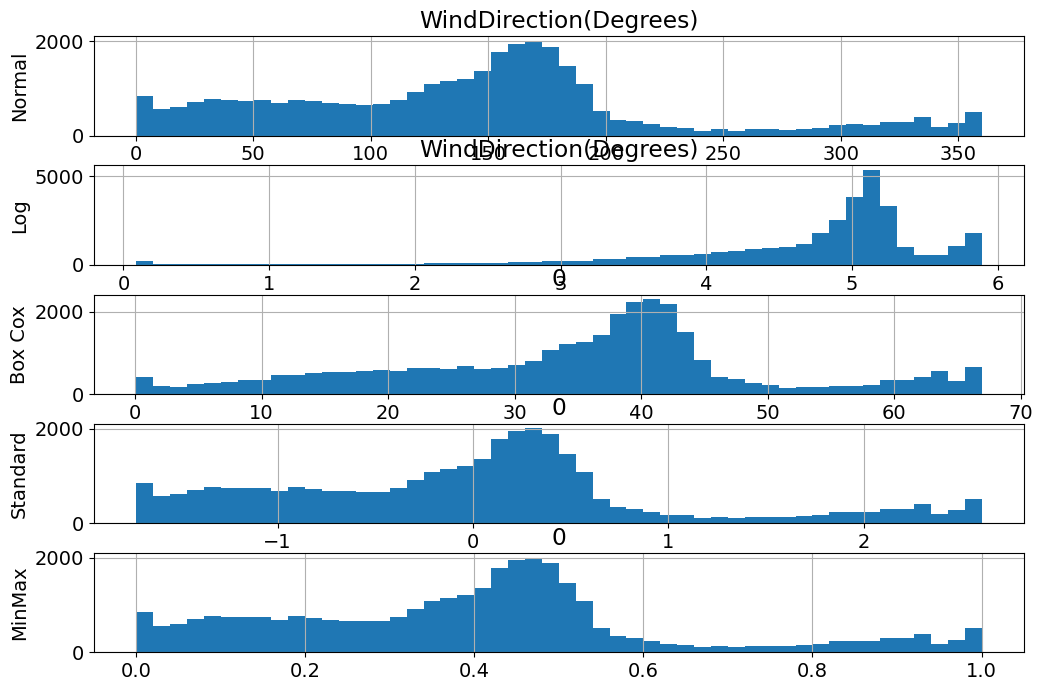

In [31]:
# Looking for transformation

features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
   
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 8))
#     This line from matplotlib creates a figure (fig) and a grid of subplots with 5 rows and 1 column (ax1 to ax5 represent the individual axes).
#     figsize=(12, 8) sets the figure size in inches.
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
     #In essence, this code snippet transforms a feature in your dataset using a logarithmic transformation and 
    #then creates a histogram to visualize the distribution of the transformed data
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [32]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [33]:
# set the transformations required

transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
             'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
             'Speed' : (input_features['Speed']+1).transform(np.log), 
             'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                 np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [34]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# <font color = 'purple'>Preparing data - Standardisation and Splitting<font/><a class = 'anchor' id = 'data_prep'/>

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

In [36]:
scaler = StandardScaler()

In [37]:
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [38]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

In [39]:
RS = 1811

# <font color = 'cyan'>Prediction with XGBoost<font/>

In [40]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

In [41]:
model = XGBRegressor(**params)

In [42]:
# train the model

model.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [43]:
y_pred = model.predict(xtest)

In [44]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)
r21=r2
print("Testing performance ~")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance ~
RMSE: 81.45
R2: 0.93


# <font color = 'cyan'>Prediction with MultiLayer Perceptron<font/><a class = 'anchor' id = 'perceptron'/>

In [45]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.add(Dropout(0.33))
model.add(Dense(1, activation='linear'))
model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,291 (48.01 KB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 175.5552 - mse: 109057.2188 - val_loss: 101.2185 - val_mse: 38182.7578
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 125.2869 - mse: 66200.2344 - val_loss: 95.9631 - val_mse: 34448.1836
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 122.2403 - mse: 63538.3828 - val_loss: 87.6823 - val_mse: 28858.3008
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 121.7449 - mse: 63395.4844 - val_loss: 91.3164 - val_mse: 31037.6719
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 119.7218 - mse: 63232.3711 - val_loss: 85.6588 - val_mse: 28021.6836
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 117.2474 - mse: 60378.0039 - val_loss: 89.7648 - val_mse: 29937.2305
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 117.9696 - mse: 61763.3281 - val_loss: 92.4599 - val_mse: 31198.1973
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 114.6640 - mse: 60163.9492 - val_lo

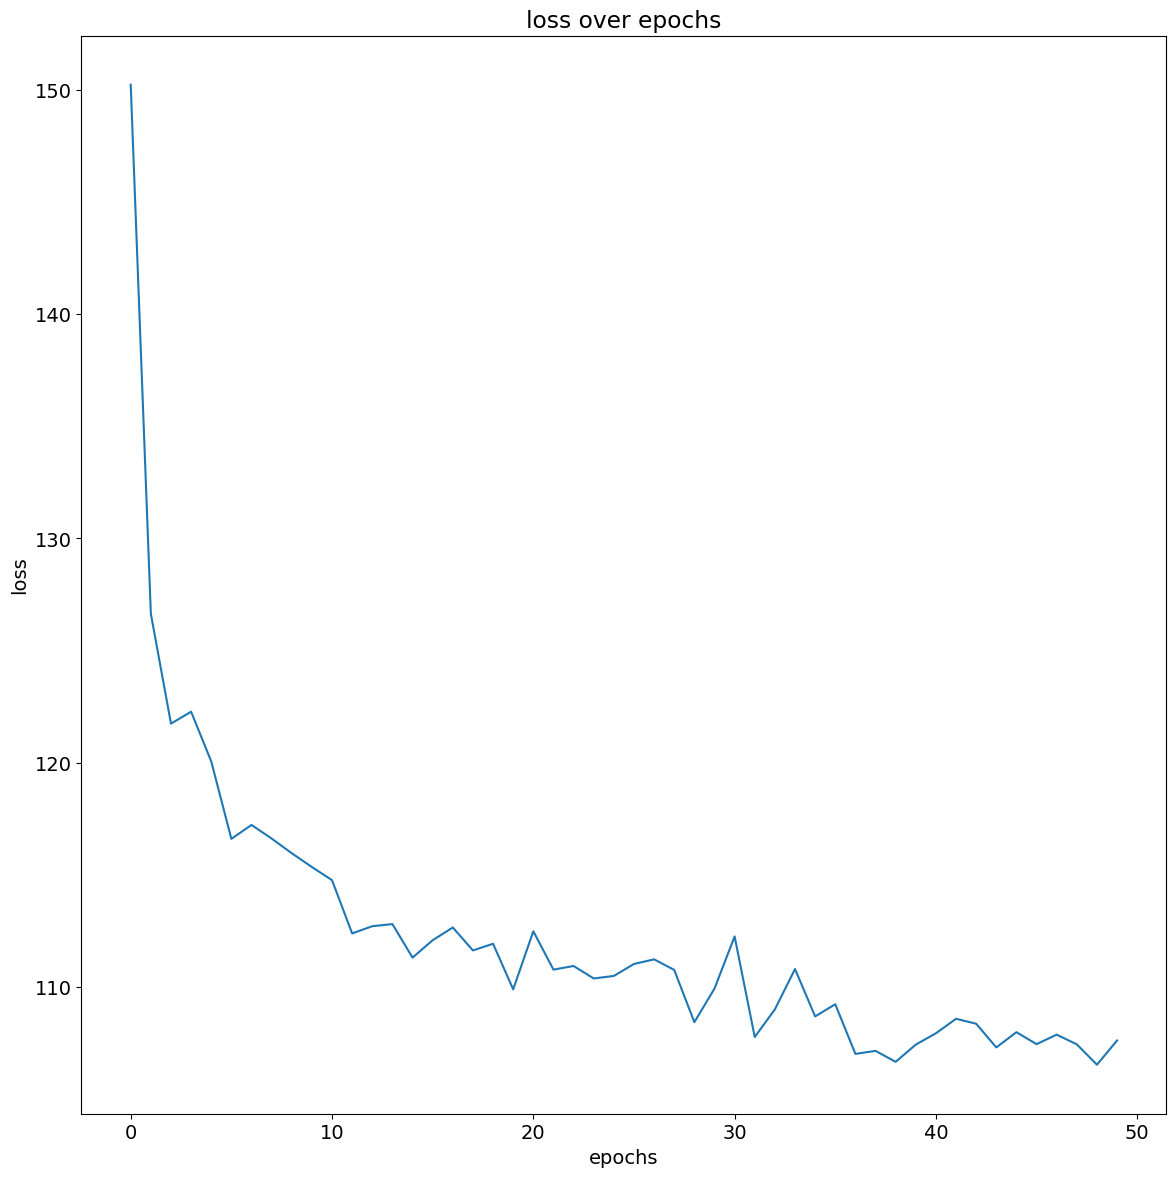

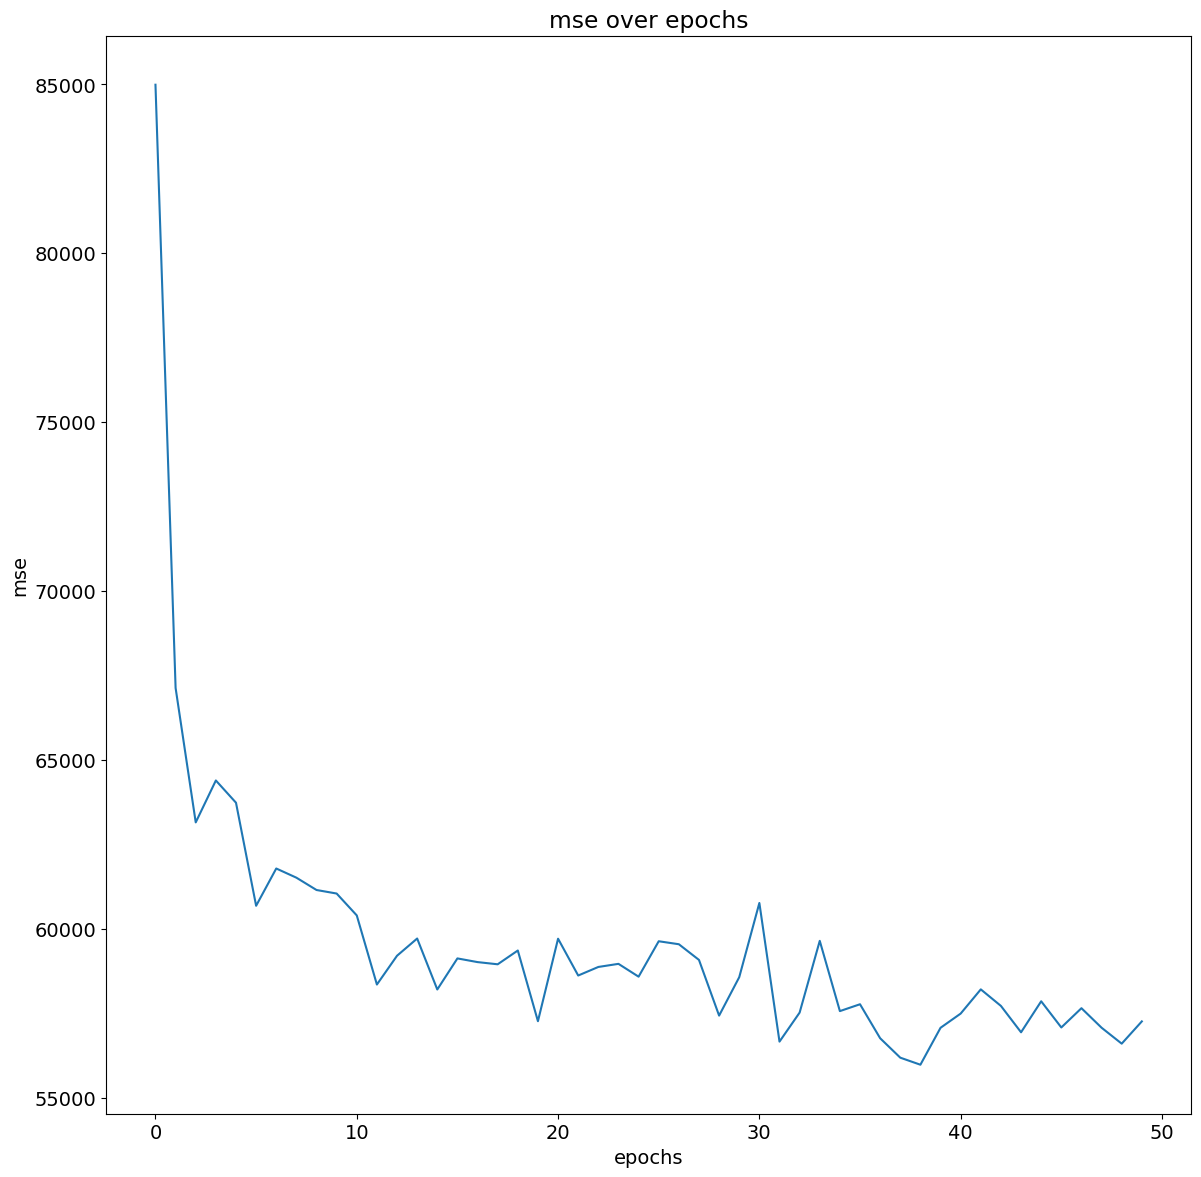

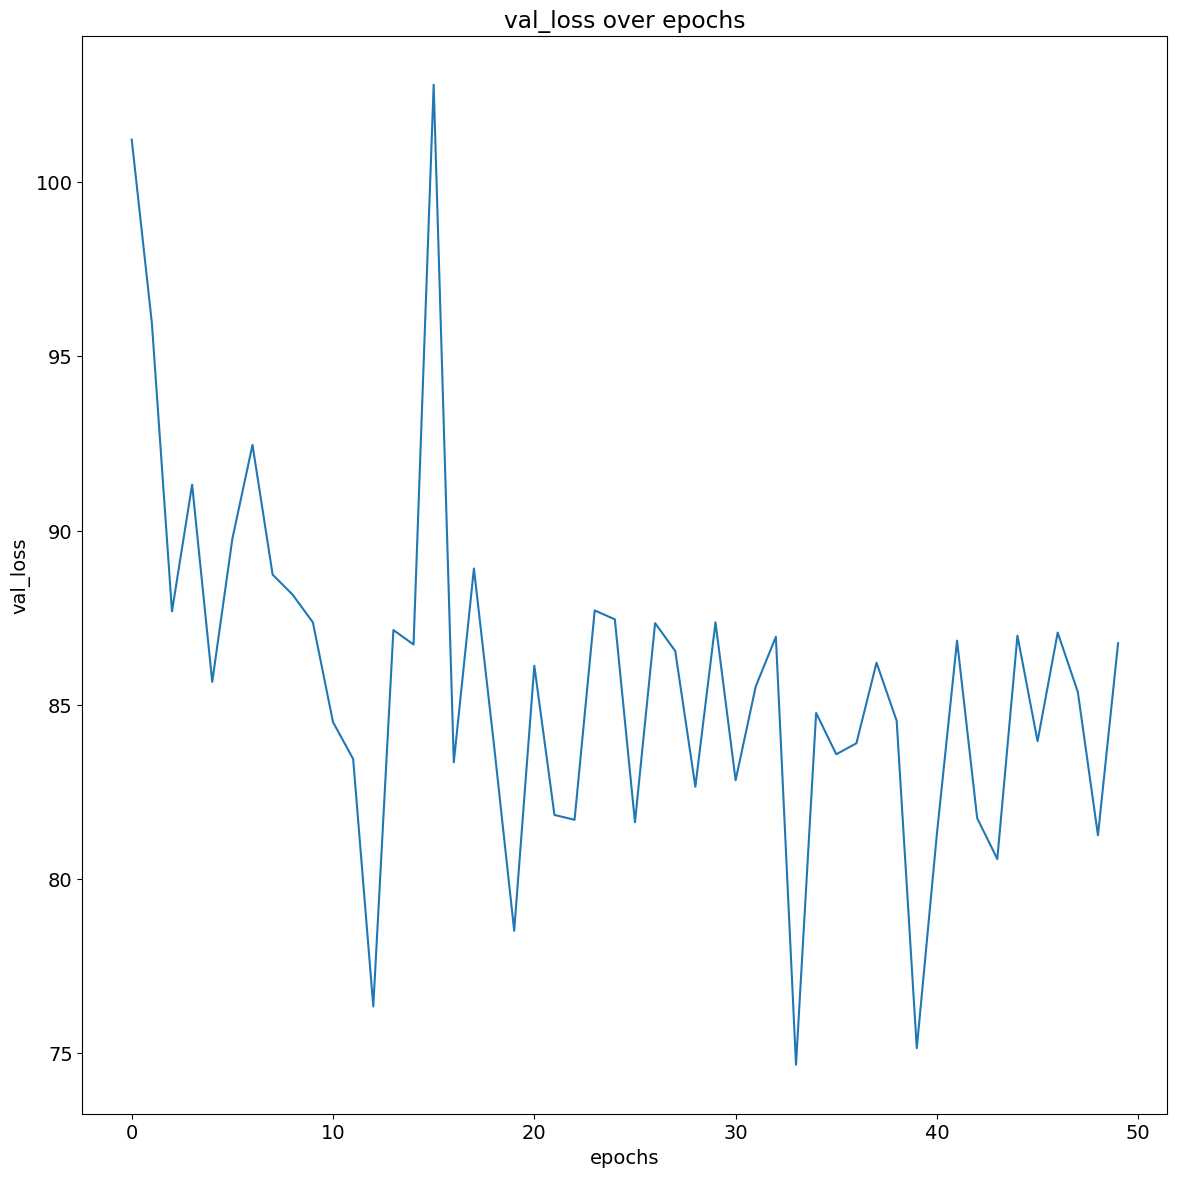

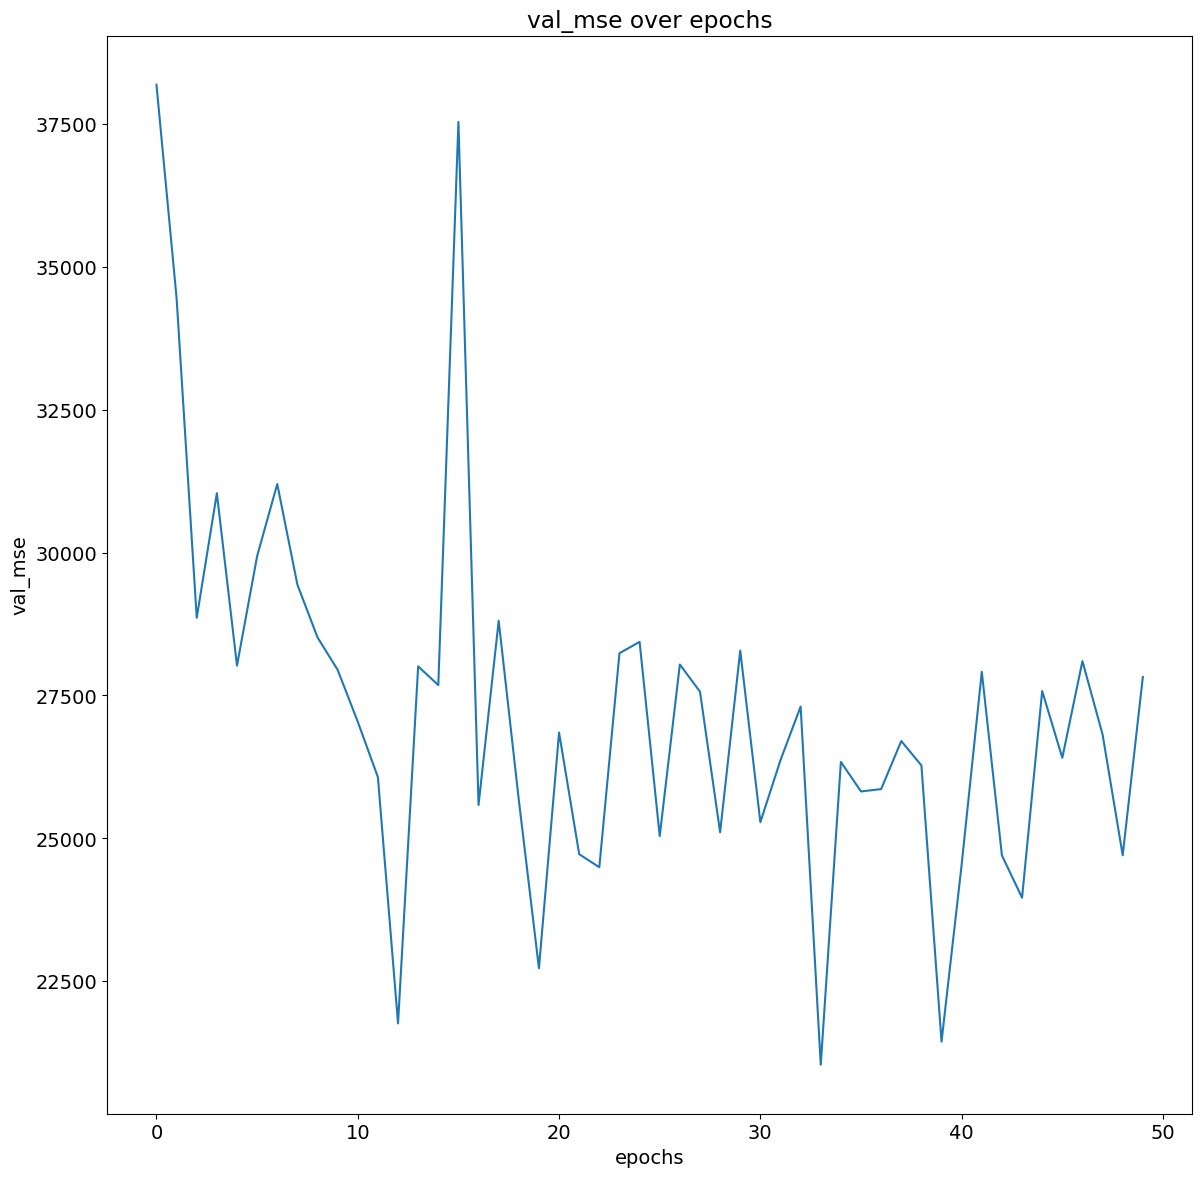

In [47]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [48]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0947 - mse: 27855.8398


In [49]:
print('Mean absolute error: ', mae)
print('Mean squared error: ', mse)

Mean absolute error:  83.88591003417969
Mean squared error:  27335.44921875


In [50]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


83.88588805744648

# <font color = 'cyan'>Predictions using single models<font/><a class = 'anchor' id = 'perceptron'/>

In [59]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
lr = LinearRegression().fit(xtrain, ytrain)
print('train', lr.score(xtrain, ytrain))
print('test', lr.score(xtest, ytest))

train 0.6119534517151768
test 0.6029913936893875


In [64]:
mlp = MLPRegressor(random_state=RS).fit(xtrain, ytrain)
print('train', mlp.score(xtrain, ytrain))
print('test', mlp.score(xtest, ytest))

train 0.8634017139425714
test 0.8604583594750843


In [67]:
dtr = DecisionTreeRegressor(random_state=RS).fit(xtrain, ytrain)
print('train', dtr.score(xtrain, ytrain))
print('train', dtr.score(xtest, ytest))

train 1.0
train 0.8880558449654175


In [70]:
gbr = GradientBoostingRegressor(random_state=RS).fit(xtrain, ytrain)
print('train', gbr.score(xtrain, ytrain))
print('test', gbr.score(xtest, ytest))

train 0.8874624934110285
test 0.8838046279261841


In [72]:
xgb = XGBRegressor(random_state=RS).fit(xtrain, ytrain)
print('train', xgb.score(xtrain, ytrain))
print('test', xgb.score(xtest, ytest))

train 0.9693800608999056
test 0.9238584524462469


In [73]:
rfr = RandomForestRegressor(random_state=RS).fit(xtrain, ytrain)
print('train', rfr.score(xtrain, ytrain))
print('test', rfr.score(xtest, ytest))

train 0.9916930169420229
test 0.9326030076815317


# <font color = 'cyan'>Predictions using 2-level models<font/><a class = 'anchor' id = 'perceptron'/>

In [52]:
lr = LinearRegression().fit(xtrain, ytrain)
mlp = MLPRegressor(random_state=RS).fit(xtrain, ytrain)
dtr = DecisionTreeRegressor(random_state=RS).fit(xtrain, ytrain)
gbr = GradientBoostingRegressor(random_state=RS).fit(xtrain, ytrain)
xgb = XGBRegressor(random_state=RS).fit(xtrain, ytrain)
rfr = RandomForestRegressor(random_state=RS).fit(xtrain, ytrain)

In [53]:
from sklearn.ensemble import StackingRegressor

def func(combine):
  estimators = [
                  ('mlp', mlp),
                  ('dt', dtr),
                  ('gbr', gbr),
                  ('rfr', rfr), 
                  ('xgb', xgb)
                ]
  final_estimator = combine
  reg = StackingRegressor(estimators=estimators,final_estimator=final_estimator)
  reg = reg.fit(xtrain, ytrain)
  print('train', reg.score(xtrain, ytrain))
  print('test', reg.score(xtest, ytest))

In [87]:
func(SVR())

train 0.982385290490439
test 0.9310649083802972


In [86]:
func(LinearRegression())

train 0.9886518261902313
test 0.9327827578594184


In [54]:
func(MLPRegressor(random_state=RS))

train 0.9878041276244376
test 0.9331153555147086


In [55]:
func(DecisionTreeRegressor(random_state=RS))

train 0.9321681139339195
test 0.8671667942960137


In [56]:
func(GradientBoostingRegressor(random_state=RS))

train 0.9858081722785789
test 0.930635478067913


In [57]:
func(XGBRegressor(random_state=RS))

train 0.9799237371579157
test 0.9249438296551968


In [58]:
func(RandomForestRegressor(random_state=RS))

train 0.9829480151222091
test 0.926073291704985


# <font color = 'cyan'>Predictions using 3-level models<font/><a class = 'anchor' id = 'perceptron'/>

In [1]:
estimators1 = [
                ('mlp', mlp),
                ('dt', dtr),
                ('gbr', gbr),
                ('rfr', rfr), 
                ('xgb', xgb)
              ]

final_estimator21 = LinearRegression()
reg1 = StackingRegressor(estimators=estimators1, final_estimator=final_estimator21)
reg1.fit(xtrain, ytrain)

final_estimator22 = GradientBoostingRegressor(random_state=RS)
reg2 = StackingRegressor(estimators=estimators1, final_estimator=final_estimator22)
reg2.fit(xtrain, ytrain)

estimators2 = [
                ('reg1', reg1),
                ('reg2', reg2),
              ]

final_estimator3 = GradientBoostingRegressor(random_state=RS)
reg3 = StackingRegressor(estimators=estimators2,final_estimator=final_estimator3)
reg3.fit(xtrain, ytrain)

print('train', reg3.score(xtrain, ytrain))
print('test', reg3.score(xtest, ytest))

NameError: name 'mlp' is not defined